# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# CUDA 10

I was not able to use Tesla K80 (in Colab) card with CUDA 11. That is why I downgraded to CUDA 10.

In [2]:
%cd /usr/local/

/usr/local


In [3]:
!pwd

/usr/local


In [4]:
!ls

bin	   cuda-10.1  cuda-11.1  _gcs_config_ops.so  licensing	share
cuda	   cuda-11    etc	 include	     man	src
cuda-10.0  cuda-11.0  games	 lib		     sbin	xgboost


In [5]:
!rm -rf cuda
!ln -s /usr/local/cuda-10.0 /usr/local/cuda

In [6]:
!stat cuda

  File: cuda -> /usr/local/cuda-10.0
  Size: 20        	Blocks: 0          IO Block: 4096   symbolic link
Device: 24h/36d	Inode: 2359310     Links: 1
Access: (0777/lrwxrwxrwx)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2022-05-04 17:59:24.437146285 +0000
Modify: 2022-05-04 17:59:24.324146499 +0000
Change: 2022-05-04 17:59:24.324146499 +0000
 Birth: -


In [7]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [8]:
!nvidia-smi

Wed May  4 17:59:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
%cd /content/

/content


In [10]:
!pwd

/content


# 2. Filtering

In [21]:
%%writefile filter.cu

#include <stdio.h>
#include <stdint.h>

#define STB_IMAGE_IMPLEMENTATION
#include "stb_image.h"

#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image_write.h"

__global__ void NonLinearFilter(int h, int w,  double *cuda_image, double *cuda_res)
{
    int globalidx = threadIdx.x + blockDim.x * blockIdx.x;
    int j = globalidx / w / 3;
    int i = globalidx / 3 - j * w;
    int ch = globalidx - i * 3 - j * w * 3;
  
    long int size = h * w * 3;	
 
    double colors[121];

	if (globalidx < size)
	{
      if (i < 4 || j < 4 || i > w - 5 || j > h - 5) cuda_res[j*w*3 + i*3 + ch] =  cuda_image[j*w*3 + i*3 + ch];
		  else
		  {
        int count = 0;
			  for (int indi = -5; indi < 6; indi++)
			  {
            for (int indj = -5; indj < 6; indj++)
            {
                colors[count] = cuda_image[(j + indj)*w*3 + (i+indi)*3 + ch];
					      count++;	
				    }
			  }
			
			double x = 0;
			for (int indi = 0; indi < 120; indi++)
			{
          for (int indj = indi + 1; indj < 121; indj++)
				  {
              if (colors[indi] < colors[indj])
              {
                  x = colors[indi];
                  colors[indi] = colors[indj];
                  colors[indj] = x;
               }
       	  }
			}
			cuda_res[j*w*3 + i*3 + ch] = colors[60];
		}
	}
}


__global__ void Filter(int h, int w, double *kernel, double *cuda_image, double *cuda_res)
{
    int globalidx = threadIdx.x + blockDim.x * blockIdx.x;
    int j = globalidx / w / 3;
    int i = globalidx / 3 - j * w;
    int ch = globalidx - i * 3 - j * w * 3; 
 
    long int size = h * w * 3;	
 
    if (globalidx < size)
	  {
        if (i == 0 || j == 0 || i == w - 1 || j == h - 1) cuda_res[j*w*3 + i*3 + ch] =  cuda_image[j*w*3 + i*3 + ch];
		    else
		    {
          cuda_res[j*w*3 + i*3 + ch] =  (cuda_image[j*w*3 + i*3 + ch]*kernel[4] + \
																				 cuda_image[(j + 1) *w * 3 + (i - 1) * 3 + ch]*kernel[0] + \
																				 cuda_image[(j + 1) *w * 3 + (i + 1) * 3 + ch]*kernel[8] + \
																				 cuda_image[(j - 1) *w * 3 + (i - 1) * 3 + ch]*kernel[6] + \
																				 cuda_image[(j - 1) *w * 3 + (i + 1) * 3 + ch]*kernel[2] + \
																				 cuda_image[(j + 1) *w * 3 + i * 3 + ch]*kernel[3] + \
																				 cuda_image[j *w * 3 + (i - 1) * 3 + ch]*kernel[1] + \
																				 cuda_image[(j - 1) *w * 3 + i * 3 + ch]*kernel[5] + \
																				 cuda_image[j * w * 3 + (i + 1)*3 + ch]*kernel[7]); 
		   }
	  if (cuda_res[j*w*3 +i*3 + ch] < 0) cuda_res[j*w*3 + i*3 + ch] = 0;
	  }
}


int main(int argc, char **argv)
{
	int w, h, bpp, size;
	double *kernel = (double *) calloc(sizeof(double), 9);
 	double *cuda_kernel;
	
	char *filter;
	filter = (char *) malloc(sizeof(char) * (strlen(argv[1] + 1)));
	filter = argv[1];
	
	if (strcmp(filter, "edge") == 0)
	{
      kernel[0] = kernel[6] = kernel[2] = kernel[8] = -1;
      kernel[1] = kernel[3] = kernel[7] = kernel[5] = -1;
      kernel[4] = 8;
	}
  
  if (strcmp(filter, "gaussian") == 0)
  {
			kernel[0] = kernel[6] = kernel[2] = kernel[8] = 1 / 16.;
			kernel[1] = kernel[3] = kernel[7] = kernel[5] = 2 / 16.;
			kernel[4] = 3 / 50.;
  }

  if (strcmp(filter, "median") != 0)
  {
      cudaMalloc(&cuda_kernel, sizeof(double)*9);
	    cudaMemcpy(cuda_kernel, kernel, sizeof(double) * 9, cudaMemcpyHostToDevice);	
  }

	uint8_t* image = stbi_load("tree.jpg", &w, &h, &bpp, 3);	
	size = h * w * 3;
	
	double * buf = (double *) malloc(sizeof(double) * size);

	double *cuda_image;
	double *cuda_res;

	cudaMalloc(&cuda_image, sizeof(double) * size);
	cudaMalloc(&cuda_res, sizeof(double) * size);

	for (int i = 0; i < size; i++) buf[i] = (double) image[i];
	
	cudaMemcpy(cuda_image, buf, sizeof(double) * size, cudaMemcpyHostToDevice);

  int block_size = h, grid_size = size / h;

  dim3 dimBlock(block_size);
  dim3 dimGrid(grid_size);

  if (strcmp(filter, "median") != 0) Filter<<<dimGrid, dimBlock>>>(h, w, cuda_kernel, cuda_image, cuda_res);
  else NonLinearFilter<<<dimGrid, dimBlock>>>(h, w, cuda_image, cuda_res);

	cudaDeviceSynchronize();	
	
	double *buf_res = (double *)malloc(sizeof(double) * size);
	cudaMemcpy(buf_res, cuda_res, sizeof(double) * size, cudaMemcpyDeviceToHost);
	
  for (int i = 0; i < size; i++) image[i] = uint8_t (buf_res[i]);

	stbi_write_png("tree_filtered.png", w, h, 3, image, w * 3);

	free(image);
	free(buf);
	cudaFree(cuda_image);
	cudaFree(cuda_res);
}

Overwriting filter.cu


In [22]:
# !./a.out median/gaussian/edge

!nvcc filter.cu
!./a.out median

stb_image.h(4096): warning: variable "old_limit" was set but never used

stb_image.h(4975): warning: variable "idata_limit_old" was set but never used



# 3. Histogram

To run the code `tree.jpg` , `stb_image.h` , `stb_iamge_write.h` files are needed (from GitHub repo)

In [ ]:
%%writefile histogram.cu

#include <stdio.h>
#include <stdint.h>

#define STB_IMAGE_IMPLEMENTATION
#include "stb_image.h"

#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image_write.h"

__global__ void GrayScale(uint8_t *im, unsigned int *hist_bin, int N)
{
    int myId = threadIdx.x + blockDim.x * blockIdx.x;
    atomicAdd(&hist_bin[im[myId] % N], 1);
}


int main(int argc, char **argv)
{
	int N = 256, CHANNELS = 3; 
	int w, h, c;

	uint8_t* image = stbi_load("tree.jpg", &w, &h, &c, 3);

	int block = N, grid = h * w / N;
	
  dim3 Block(block);
  dim3 Grid(grid);
	
  uint8_t *im;
	
  unsigned int *hist;
	unsigned int *res = (unsigned int *) malloc(sizeof(unsigned int) * 256);

	FILE *f;
	f = fopen("data.txt", "wb");
	
	cudaMalloc(&im, sizeof(uint8_t) * h * w);
  cudaMalloc(&hist, sizeof(unsigned int) * N);
  
  cudaMemset(hist, 0, sizeof(unsigned int) * N);	
	
  uint8_t* image_gray = (uint8_t *) malloc(sizeof(uint8_t) * h * w);

  for (int i = 0; i < h; i++)
  {
      for (int j = 0; j < w; j++)
      {
          int s_ch = 0;
          for (int ch = 0; ch < CHANNELS; ch++) s_ch += image[i*w*CHANNELS + j*CHANNELS + ch];
          image_gray[i*w + j] = s_ch / 3;
      }
  }

	cudaMemcpy(im, image_gray, sizeof(uint8_t) * h * w, cudaMemcpyHostToDevice);
 
	GrayScale<<<Grid, Block>>>(im, hist, N);
	cudaDeviceSynchronize();	
 
	cudaMemcpy(res, hist, sizeof(unsigned int) * N, cudaMemcpyDeviceToHost);
	
  for (int i = 0; i < N; i++) fprintf(f, "%d\n", res[i]);
 
	free(image_gray);
	free(res);
	cudaFree(im);
	cudaFree(hist);
	fclose(f);
}

Overwriting histogram.cu


In [ ]:
!nvcc histogram.cu
!./a.out

stb_image.h(4096): warning: variable "old_limit" was set but never used

stb_image.h(4975): warning: variable "idata_limit_old" was set but never used



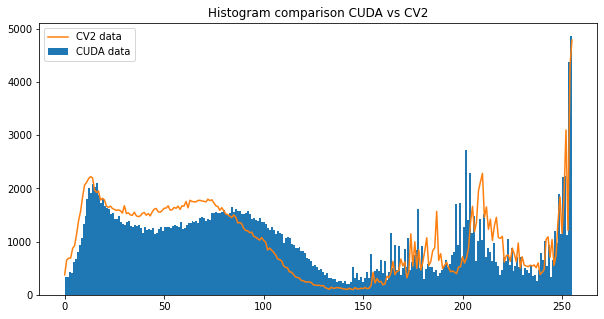

In [ ]:
y = []
with open('data.txt') as file: 
  for line in file: y.append(int(line))

img = cv2.imread('tree.jpg', 0)

plt.figure(figsize=(10, 5))
plt.title('Histogram comparison CUDA vs CV2')
plt.hist(img.flatten(), bins=256, label='CUDA data')
plt.plot(np.arange(256), y, label='CV2 data')
plt.legend();